In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from sklearn.metrics import mean_squared_error
import astropy.units as u
import astropy.constants as cons

plt.rcParams['figure.figsize'] = (10,7)
plt.rcParams['font.size'] = 16

# Problem 1: Synthesized Beams

## a) 2D positions of anthenas

We see that the extent of the A-array in both EW and NS directions is approximately 36km, which is what we roughly expect to see. We also note that the distribution looks very similar in the NS and EW direction, giving the array some symmetry. We see similar patterns in the D-array, except this array configuration has a much smaller extent and has what looks like an extra (and smaller) arm in the south direction. 

Looking at the vertical scatter $v_s$, we have the following RMS for each of the arrays:

$$v_{s, A}  = 19.87 $$
$$v_{s, D}  = 0.81$$

We see that both of them are very small compared to the NS and SW extents and it makes sense that the vertical scatter for the D-array configuration is much smaller, as the impact of the curvature of the Earth is less for lesser extents. 

In [2]:
# loading in the data
vlaA = np.loadtxt('./vla_a_array.txt')[:,:3]*1e-9*3e8  # convert to m
vlaD = np.loadtxt('./vla_d_array.txt')[:,:3]*1e-9*3e8  # convert to m


In [3]:
duA = 40.0
duD = 2.0

lat = (34.1*u.deg).to(u.rad).value # latitude of VLA in rad

zenith = [np.cos(lat), 0, np.sin(lat)]
east = [0, 1, 0]
north = np.cross(zenith, east)

mat = np.vstack([north,east,zenith])

xyza = vlaA@mat.T
xyzd = vlaD@mat.T

ewa = xyza[:,1]
nsa = xyza[:,0]
upa = xyza[:,2]

ewd = xyzd[:,1]
nsd = xyzd[:,0]
upd = xyzd[:,2]

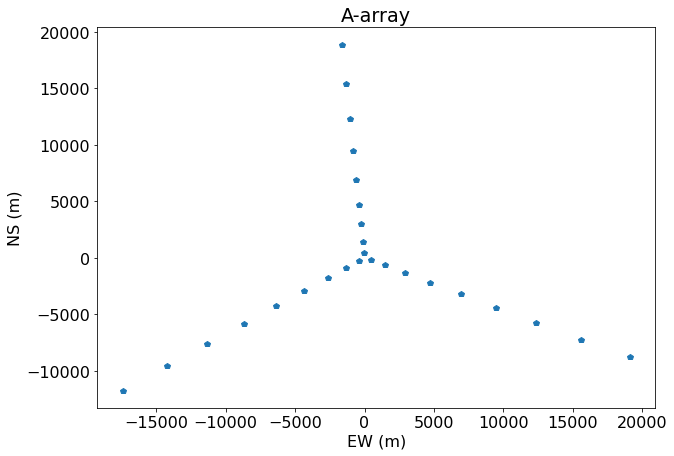

In [4]:
plt.plot(ewa, nsa, 'p')
plt.xlabel('EW (m)')
plt.ylabel('NS (m)')
plt.title('A-array')
plt.show()

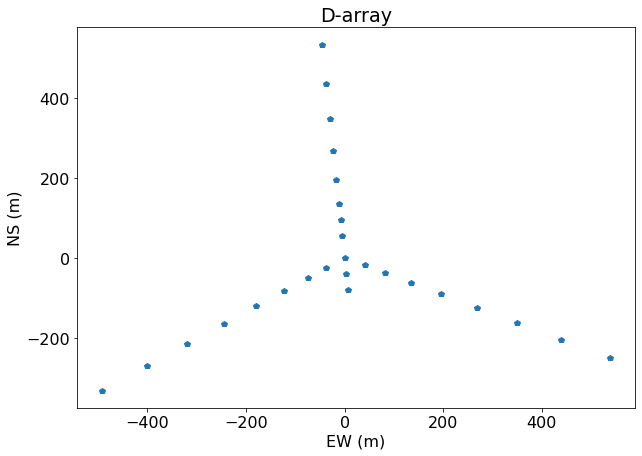

In [5]:
plt.plot(ewd, nsd, 'p')
plt.xlabel('EW (m)')
plt.ylabel('NS (m)')
plt.title('D-array')
plt.show()

In [6]:
RMSa = np.sqrt(mean_squared_error(upa, np.zeros(len(upa)))) 
RMSd = np.sqrt(mean_squared_error(upd, np.zeros(len(upd)))) 

print('The RMS scatter is RMS = {} for array-A \nThe RMS scatter is RMS = {} for array-D'.format(RMSa, RMSd))

The RMS scatter is RMS = 19.873410538544693 for array-A 
The RMS scatter is RMS = 0.8127155170471895 for array-D


## b) UV plot

In [279]:
nant = vlaA.shape[0]      # number of antennas
nvis = nant*(nant-1)//2   # number of visibilities

In [8]:
uvA = np.zeros([nvis, 2])
uvD = np.zeros([nvis, 2])
icur = 0
for i in range(nant):
    for j in range(i+1,nant):
        uvA[icur,:] = xyza[i,:2] - xyza[j,:2]
        uvD[icur,:] = xyzd[i,:2] - xyzd[j,:2]
        icur += 1

uvA = np.vstack([uvA,-1*uvA]) #get the visibility conjugates
uvD = np.vstack([uvD,-1*uvD])

v = (1.4 * u.GHz).to(u.s**-1)
wav = cons.c / v

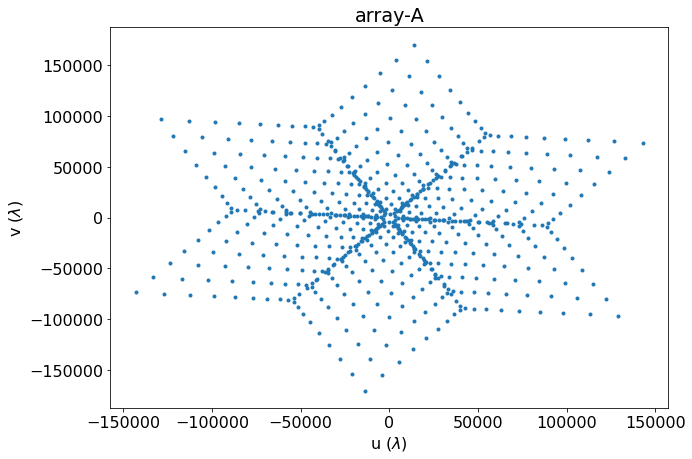

In [9]:
plt.plot(uvA[:,0]/wav, uvA[:,1]/wav, '.')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.title('array-A')
plt.show()

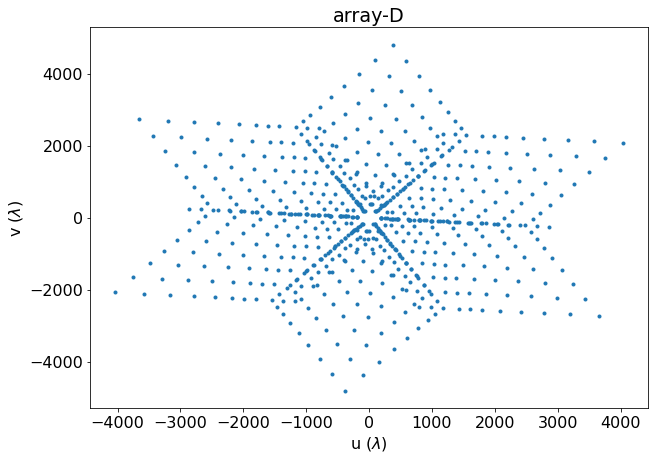

In [10]:
plt.plot(uvD[:,0]/wav, uvD[:,1]/wav, '.')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.title('array-D')
plt.show()

## c) dirty beam

To get the dirty beam for the UV coverage of both A and D arrays, I took the fourier transform of the UV coverage matrix. I created this matrix using the code that Jon provided. 

Then, after having the beam, I fitted a gaussian to it using Newton's method in order to determine its width and therefore its FWHM value. Using:

$$\theta_{FWHM} = 2 \sqrt{2log(2)}\times\sigma$$

In addition to that, the value found for the FWHM is returned in pixels, and so to normalize it and convert it into physical units of arcseconds, I divided by the size of the array (equivalent to number of pixels) and by the u resolution of the grid. The results for the FWHM estimates are:

$$\theta_{FWHM, \ A} = 1.48 ''$$
$$\theta_{FWHM, \ D} = 29.31 ''$$

These values are close to what we expect for the VLA A and D arrays at $\nu = 1.4GHz$, so I believe I did the normalization properly. 

In [11]:
uv_3dA=np.zeros([nvis,3])
uv_3dD=np.zeros([nvis,3])
icur=0
for i in range(nant):
    for j in range(i+1,nant):
        uv_3dA[icur,:]=vlaA[i,:]-vlaA[j,:]
        uv_3dD[icur,:]=vlaD[i,:]-vlaD[j,:]
        icur+=+1

uv_3dA=np.vstack([uv_3dA,-uv_3dA])
uv_3dD=np.vstack([uv_3dD,-uv_3dD])

In [12]:
t = 0
theta = t*2*np.pi/24

proj_mat=np.vstack([east, north])

In [511]:
uv_rotA.shape

(702, 3)

In [13]:
pad = 4
szA = int(np.max(np.abs(uv_3dA))/duA)
szD = int(np.max(np.abs(uv_3dD))/duD)

uv_matA = np.zeros([pad*2*szA,2*pad*szA])
uv_matD = np.zeros([pad*2*szD,2*pad*szD])

rot_mat = np.zeros([3,3])
rot_mat[0,0] = np.cos(theta)
rot_mat[1,1] = np.cos(theta)
rot_mat[2,2] = 1.0
rot_mat[0,1] = np.sin(theta)
rot_mat[1,0] = -np.sin(theta)

uv_rotA = uv_3dA @ rot_mat
uv_rotD = uv_3dD @ rot_mat

uv_snapA = uv_rotA @ proj_mat.T
uv_snapD = uv_rotD @ proj_mat.T

uv_intA = np.asarray(uv_snapA/duA,dtype='int')
uv_intD = np.asarray(uv_snapD/duD,dtype='int')

for i in range(uv_snapA.shape[0]):
    uv_matA[uv_intA[i,0],uv_intA[i,1]] = uv_matA[uv_intA[i,0],uv_intA[i,1]]+1
    uv_matD[uv_intD[i,0],uv_intD[i,1]] = uv_matD[uv_intD[i,0],uv_intD[i,1]]+1

In [14]:
beamA_initial = np.fft.fftshift(np.abs(np.fft.ifft2(uv_matA)))
beamD_initial = np.fft.fftshift(np.abs(np.fft.ifft2(uv_matD)))

In [15]:
np.save('beamA', beamA_initial)
np.save('beamD', beamD_initial)

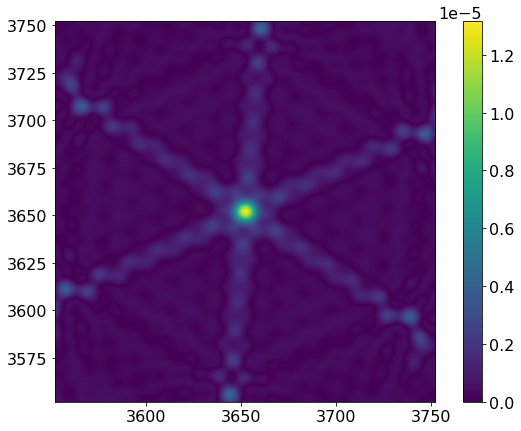

In [16]:
xA = beamA_initial.shape[0]//2
dx = 100

plt.imshow(beamA_initial)
plt.xlim([xA-dx,xA+dx])
plt.ylim([xA-dx,xA+dx])
plt.colorbar()
plt.show()

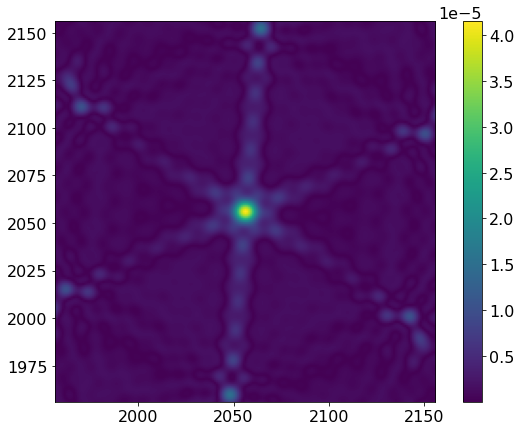

In [17]:
xD = beamD_initial.shape[0]//2
dx = 100

plt.imshow(beamD_initial)
plt.xlim([xD-dx,xD+dx])
plt.ylim([xD-dx,xD+dx])
plt.colorbar()
plt.show()

In [18]:
def mygauss(pars, width):
    vec = np.asarray(np.arange(-width,width),dtype='float')
    amp=pars[0]
    dx=pars[1]
    dy=pars[2]
    sig=pars[3]
    shift = pars[4]                             

    xvec=vec-dx
    yvec=vec-dy
    xmat=np.outer(xvec,np.ones(len(xvec)))
    ymat=np.outer(np.ones(len(yvec)),yvec)
    rmat=xmat**2+ymat**2
    model=np.exp(-0.5*(rmat/sig**2))*amp + shift

    return model

def get_model_derivs(fun,pars,dpar,width):
    model=fun(pars,width)
    npar=len(pars)
    derivs=[None]*npar
    for i in range(npar):
        pp=pars.copy()
        pp[i]=pars[i]+dpar[i]
        m_plus=fun(pp,width)
        pp[i]=pars[i]-dpar[i]
        m_minus=fun(pp,width)
        derivs[i]=(m_plus-m_minus)/(2*dpar[i])
    return model,derivs

def get_model_derivs_ravel(fun,pars,dpar,width):
    model,derivs=get_model_derivs(fun,pars,dpar,width)
    model=np.ravel(model)
    npar=len(pars)
    derivs_out=np.empty([len(model),len(pars)])
    for i in range(npar):
        derivs_out[:,i]=np.ravel(derivs[i])
    return model,derivs_out

def newton(pars,data,fun,width,dpar,niter=30):
    for i in range(niter):
        model,derivs=get_model_derivs_ravel(fun,pars,dpar,width)
        resid=data-model
        lhs=derivs.T@derivs
        rhs=derivs.T@resid
        shift=np.linalg.inv(lhs)@rhs
        pars=pars+shift
    return pars

In [353]:
x_shift = 0
y_shift = -2
sig = 3
amp = 1e-5
shift = 1

patchA = beamA_initial[xA-dx:xA+dx, xA-dx:xA+dx]
patchD = beamD_initial[xD-dx:xD+dx, xD-dx:xD+dx]

pars = np.asarray([amp, x_shift, y_shift, sig, shift], dtype='float')
dpar = np.asarray([1.0,0.01,0.01,0.01,0.01])/1000

In [395]:
fitpA = newton(pars, np.ravel(patchA), mygauss, dx, dpar)
fwhmA = 2*np.sqrt(2*np.log(2))*fitpA[3]  # in pixels
fwhmA = fwhmA / patchA.size / duA  # normalizing

fitpD = newton(pars, np.ravel(patchD), mygauss, dx, dpar)
fwhmD = 2*np.sqrt(2*np.log(2))*fitpD[3]
fwhmD = fwhmD / patchD.size / duD  # normalizing

In [417]:
print('FWHM - A =', (fwhmA*u.rad).to(u.arcsec))
print('FWHM - D=', (fwhmD*u.rad).to(u.arcsec))

FWHM - A = 1.483574467829341 arcsec
FWHM - D= 29.309223709003128 arcsec


## d) uv coverage for 8 hours on 3 declinations

Below we see the UV coverage plots for for 3 different scenarios. In all of them, we have observed the source for a total of 8 hours, 4 before it transits overhead and 4 after. The three scenarios were:

1. Source at the equator: For this case, we see that the UV coverage has very sharp edges.
2. Source at the north celestial pole: The UV coverage is pretty uniform and circular in shape. 
3. Source directly overhead (I considered this to be at the latitude of the VLA): There are loops that look relatively independent in the u and v coordinates. 

Generally, one interesting thing I noticed is that in all cases, the very center $(u, v) = (0, 0)$ is not covered for any of the source positions. 

In [23]:
def get_uv(dec, uv_3dA, uv_3dD, duA, duD):
    
    t_range = np.linspace(-4, 4, 61)
    theta_range = t_range*2*np.pi/24
    
    zenith = np.asarray([np.cos(dec), 0, np.sin(dec)])
    east = np.asarray([0,1,0])
    north = np.cross(zenith, east)

    proj_mat=np.vstack([east, north])
    
    pad = 4
    szA = int(np.max(np.abs(uv_3dA))/duA)
    szD = int(np.max(np.abs(uv_3dD))/duD)

    uv_matA = np.zeros([pad*2*szA,2*pad*szA])
    uv_matD = np.zeros([pad*2*szD,2*pad*szD])
    
    snapsA = []
    snapsD = []

    for theta in theta_range:
        rot_mat = np.zeros([3,3])
        rot_mat[0,0] = np.cos(theta)
        rot_mat[1,1] = np.cos(theta)
        rot_mat[2,2] = 1.0
        rot_mat[0,1] = np.sin(theta)
        rot_mat[1,0] = -np.sin(theta)

        uv_rotA = uv_3dA @ rot_mat
        uv_rotD = uv_3dD @ rot_mat

        uv_snapA=uv_rotA @ proj_mat.T
        uv_snapD=uv_rotD @ proj_mat.T
        
        snapsA.append(uv_snapA)
        snapsD.append(uv_snapD)

        uv_intA=np.asarray(uv_snapA/duA,dtype='int')
        uv_intD=np.asarray(uv_snapD/duD,dtype='int')

        for i in range(uv_snapA.shape[0]):
            uv_matA[uv_intA[i,0],uv_intA[i,1]] = uv_matA[uv_intA[i,0],uv_intA[i,1]]+1
            uv_matD[uv_intD[i,0],uv_intD[i,1]] = uv_matD[uv_intD[i,0],uv_intD[i,1]]+1
            
    return np.array(snapsA), np.array(snapsD), uv_matA, uv_matD

In [510]:
snapsA_equator.shape

(61, 702, 2)

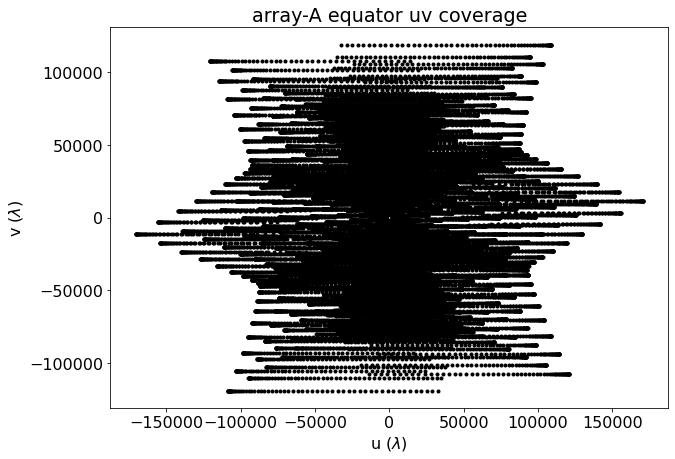

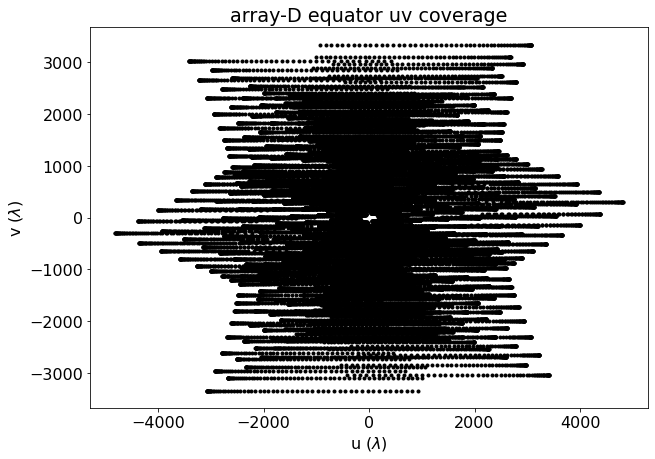

In [228]:
dec = 00.0 * (np.pi/180)
snapsA_equator, snapsD_equator, uv_matA_equator, uv_matD_equator = get_uv(dec, uv_3dA, uv_3dD, duA, duD)

for i in range(snapsA_equator.shape[0]):
    plt.plot(snapsA_equator[i, :,0]/wav, snapsA_equator[i, :,1]/wav, '.', color='black')
    
plt.title('array-A equator uv coverage')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.show()

for i in range(snapsD_equator.shape[0]):
    plt.plot(snapsD_equator[i, :,0]/wav, snapsD_equator[i, :,1]/wav, '.', color='black')
    
plt.title('array-D equator uv coverage')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.show()

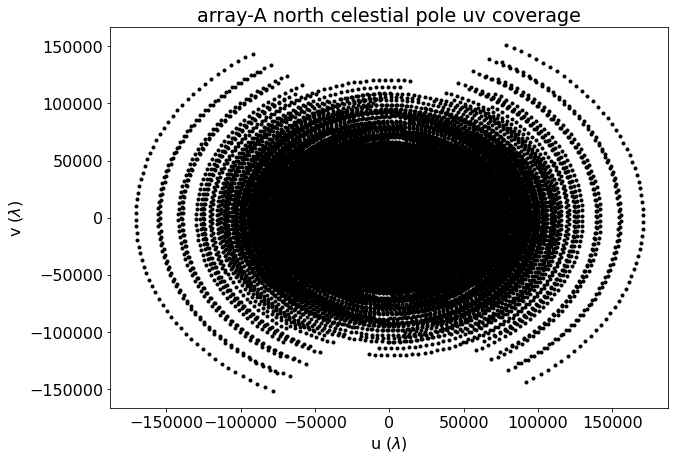

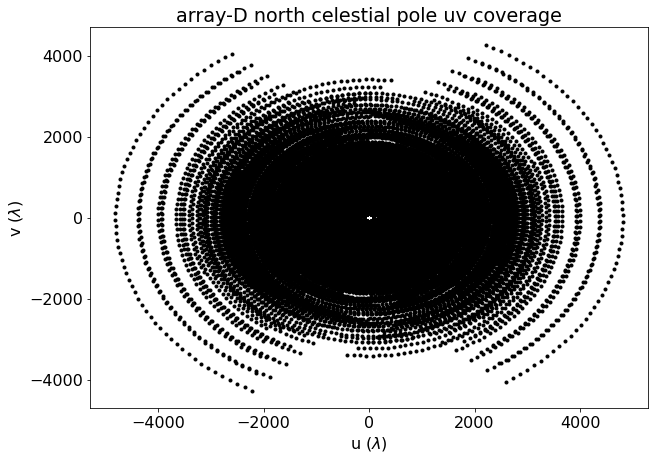

In [227]:
dec = 90 * (np.pi/180)
snapsA_north, snapsD_north, uv_matA_north, uv_matD_north = get_uv(dec, uv_3dA, uv_3dD, duA, duD)

for i in range(snapsA_north.shape[0]):
    plt.plot(snapsA_north[i, :,0]/wav, snapsA_north[i, :,1]/wav, '.', color='black')
    
plt.title('array-A north celestial pole uv coverage')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.show()

for i in range(snapsD_north.shape[0]):
    plt.plot(snapsD_north[i, :,0]/wav, snapsD_north[i, :,1]/wav, '.', color='black')
    
plt.title('array-D north celestial pole uv coverage')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.show()

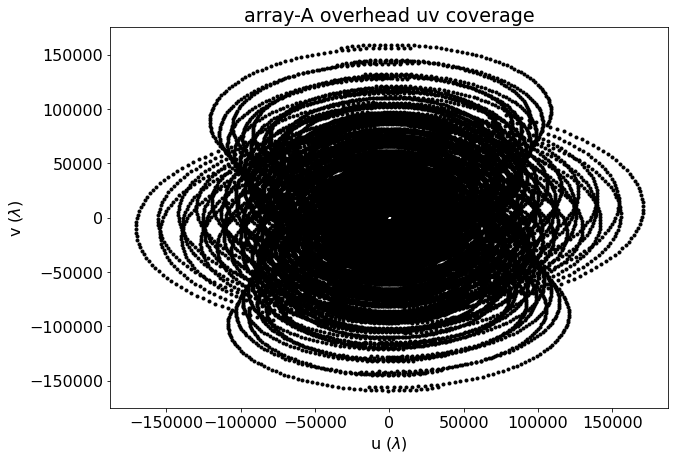

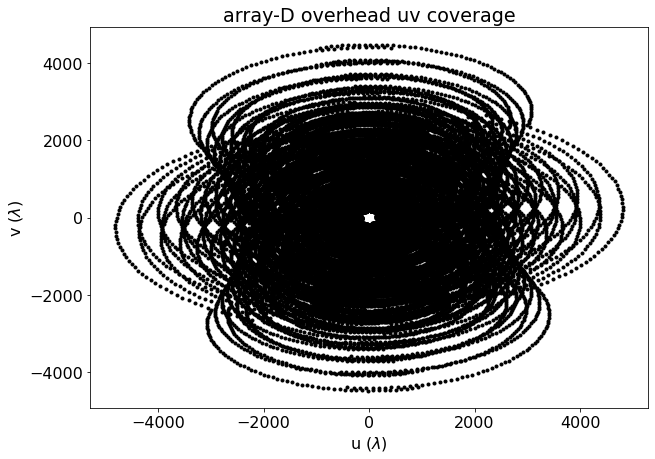

In [229]:
dec = 34.1 * (np.pi/180)
snapsA_overhead, snapsD_overhead, uv_matA_overhead, uv_matD_overhead = get_uv(dec, uv_3dA, uv_3dD, duA, duD)

for i in range(snapsA_overhead.shape[0]):
    plt.plot(snapsA_overhead[i, :,0]/wav, snapsA_overhead[i, :,1]/wav, '.', color='black')
    
plt.title('array-A overhead uv coverage')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.show()

for i in range(snapsD_overhead.shape[0]):
    plt.plot(snapsD_overhead[i, :,0]/wav, snapsD_overhead[i, :,1]/wav, '.', color='black')
    
plt.title('array-D overhead uv coverage')
plt.xlabel('u ($\lambda$)')
plt.ylabel('v ($\lambda$)')
plt.show()

In [27]:
np.save('snapsA_north', snapsA_north)
np.save('snapsD_north', snapsD_north)
np.save('uv_matA_north', uv_matA_north)
np.save('uv_matD_north', uv_matD_north)

np.save('snapsA_overhead', snapsA_overhead)
np.save('snapsD_overhead', snapsD_overhead)
np.save('uv_matA_overhead', uv_matA_overhead)
np.save('uv_matD_overhead', uv_matD_overhead)

np.save('snapsA_equator', snapsA_equator)
np.save('snapsD_equator', snapsD_equator)
np.save('uv_matA_equator', uv_matA_equator)
np.save('uv_matD_equator', uv_matD_equator)

## e) synthesized beams

Similar to before, I took the fourier transform of the UV coverages shown above to find the beams for each of the cases  The results are shown below. We still see in some way the patterns that I mentioned before, in terms of sharpness, uniformity, or different types of lobes. 

In [28]:
beamA_equator = np.fft.fftshift(np.abs(np.fft.ifft2(uv_matA_equator)))
beamD_equator = np.fft.fftshift(np.abs(np.fft.ifft2(uv_matD_equator)))

In [29]:
np.save('beamA_equator', beamA_equator)
np.save('beamD_equator', beamD_equator)

In [30]:
midA = beamA_equator.shape[0]//2
midD = beamD_equator.shape[0]//2
dx = 100

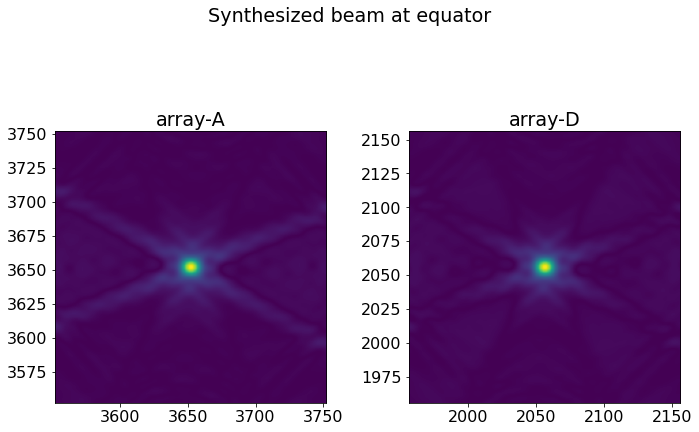

In [31]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(beamA_equator)
ax[0].set_title('array-A')
ax[0].set_xlim([midA-dx, midA+dx])
ax[0].set_ylim([midA-dx, midA+dx])

ax[1].imshow(beamD_equator)
ax[1].set_title('array-D')
ax[1].set_xlim([midD-dx, midD+dx])
ax[1].set_ylim([midD-dx, midD+dx])

plt.suptitle('Synthesized beam at equator')
plt.tight_layout()
plt.show()

In [32]:
beamA_north = np.abs(np.fft.ifft2(uv_matA_north))
beamD_north = np.abs(np.fft.ifft2(uv_matD_north))

In [33]:
np.save('beamA_north', beamA_north)
np.save('beamD_north', beamD_north)

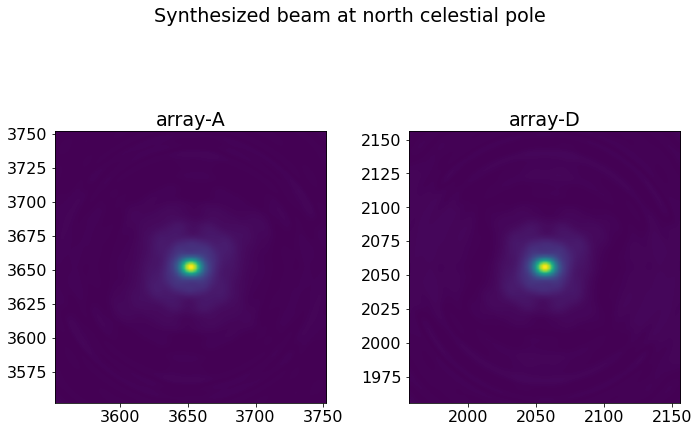

In [34]:
midA = beamA_north.shape[0]//2
midD = beamD_north.shape[0]//2
dx = 100
beamA_north = np.fft.fftshift(beamA_north)
beamD_north = np.fft.fftshift(beamD_north)

fig, ax = plt.subplots(1,2)
ax[0].imshow(beamA_north)
ax[0].set_title('array-A')
ax[0].set_xlim([midA-dx, midA+dx])
ax[0].set_ylim([midA-dx, midA+dx])

ax[1].imshow(beamD_north)
ax[1].set_title('array-D')
ax[1].set_xlim([midD-dx, midD+dx])
ax[1].set_ylim([midD-dx, midD+dx])

plt.suptitle('Synthesized beam at north celestial pole')
plt.tight_layout()
plt.show()

In [35]:
beamA_overhead = np.abs(np.fft.ifft2(uv_matA_overhead))
beamD_overhead = np.abs(np.fft.ifft2(uv_matD_overhead))

In [36]:
np.save('beamA_overhead', beamA_overhead)
np.save('beamD_overhead', beamD_overhead)

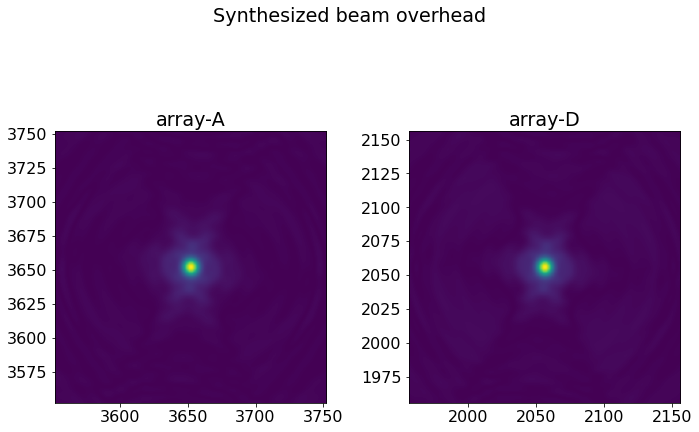

In [37]:
midA = beamA_overhead.shape[0]//2
midD = beamD_overhead.shape[0]//2
dx = 100
beamA_overhead = np.fft.fftshift(beamA_overhead)
beamD_overhead = np.fft.fftshift(beamD_overhead)

fig, ax = plt.subplots(1,2)
ax[0].imshow(beamA_overhead)
ax[0].set_title('array-A')
ax[0].set_xlim([midA-dx, midA+dx])
ax[0].set_ylim([midA-dx, midA+dx])

ax[1].imshow(beamD_overhead)
ax[1].set_title('array-D')
ax[1].set_xlim([midD-dx, midD+dx])
ax[1].set_ylim([midD-dx, midD+dx])

plt.suptitle('Synthesized beam overhead')
plt.tight_layout()
plt.show()

# Problem 2: w Term

## a) VLA field of view

The field of view is related to the dish size and the wavelength of observation. This is because further out from the resolution of the dish, the measurements will rapidly decrease in sensitivity. So we take this resolution as an approximation of the effective field of view of the dishes. The VLA has pababolic dishes, so that relationship is given by:

$$fov = 1.22 \frac{\lambda}{D}$$

The estimates for the field of view of the VLA for both $\nu = 1.4 \ GHz$ and $\nu = 8 \ GHz$ are:

$$FoV = 0.599 \ deg, \ \ for \nu = 1.4 \ GHz$$
$$FoV = 0.105 \ deg, \ \ for \nu = 8 \ GHz$$

In [501]:
fov14 = 1.22 * ((cons.c / (1.4*u.GHz)) / (25*u.m)).decompose()
fov80 = 1.22 * ((cons.c / (8*u.GHz)) / (25*u.m)).decompose()

fov14 = (fov14*u.rad).to(u.deg).value
fov80 = (fov80*u.rad).to(u.deg).value

In [502]:
print('FoV = {} rad, for f = 1.4GHz'.format(round(fov14, 5)))
print('FoV = {} rad, for f = 8GHz'.format(round(fov80, 5)))

FoV = 0.59874 rad, for f = 1.4GHz
FoV = 0.10478 rad, for f = 8GHz


## b) 2D difference in distance

For this part, I set up the source vector as $v_s = [0, sin(\theta)]$, given that we are looking at a source in the North-South Plane. For the first source I set $\theta = 0$ and for the second, I sent $\theta = 30 \ arcmin$ (converted to radians). Then finding the path length difference of each source for each baseline, I could estimate the difference in their distances. I plot this finding in the figure below for the A and D-arrays as a function of the baseline differences. We see similar patterns for both, were the longer the baseline is, the larger the difference is. This makes intuitive sense to me as closer antennas will observe the source with less of a path difference than antennas further apart independent of the configuration. In addition, we also see that the differences are much smaller for the D-array, which makes sense based on how much more compact it is. 


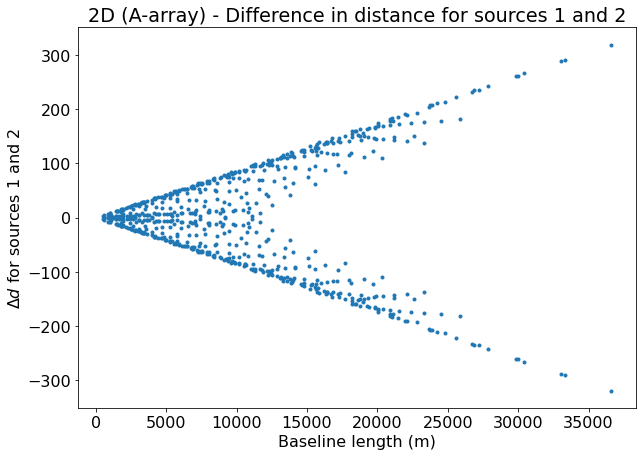

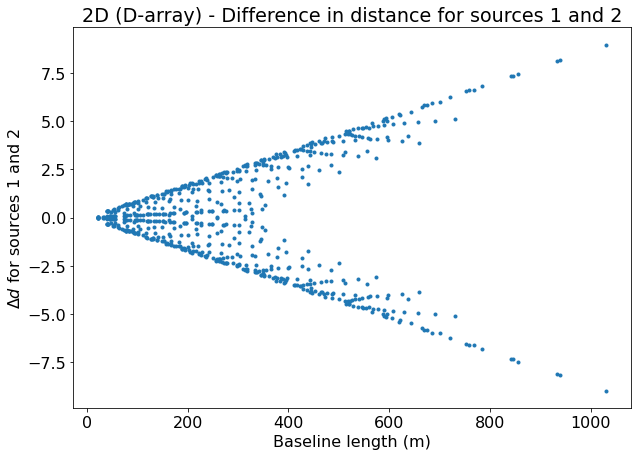

In [474]:
theta1 = 0
theta2 = -(30*u.arcmin).to(u.rad).value  # source 2 - 30 arcmin south
source_vector1 = [0, np.sin(theta1)]
source_vector2 = [0, np.sin(theta2)]

baseline_vectorA = [uv_3dA[:,0], uv_3dA[:,1]]
baseline_vectorD = [uv_3dD[:,0], uv_3dD[:,1]]

pd_2d_1A = np.dot(source_vector1, baseline_vectorA)
pd_2d_2A = np.dot(source_vector2, baseline_vectorA)
pd_2d_1D = np.dot(source_vector1, baseline_vectorD)
pd_2d_2D = np.dot(source_vector2, baseline_vectorD)

diff_2dA = pd_2d_1A - pd_2d_2A
diff_2dD = pd_2d_1D - pd_2d_2D

baseline_lengthsA = np.sqrt(uv_3dA[:,0]**2 + uv_3dA[:,1]**2)  # baseline lengths
baseline_lengthsD = np.sqrt(uv_3dD[:,0]**2 + uv_3dD[:,1]**2)  # baseline lengths

plt.plot(baseline_lengthsA, diff_2dA, '.')
plt.xlabel('Baseline length (m)')
plt.ylabel('$\Delta d$ for sources 1 and 2')
plt.title('2D (A-array) - Difference in distance for sources 1 and 2')
plt.show()

plt.plot(baseline_lengthsD, diff_2dD, '.')
plt.xlabel('Baseline length (m)')
plt.ylabel('$\Delta d$ for sources 1 and 2')
plt.title('2D (D-array) - Difference in distance for sources 1 and 2')
plt.show()

## c) 3D antenna - RMS difference of differences

For this part, I took the full 3D positions of the antenna, instead of ignoring the up and down scatter of their configuration. Because of that, I took the full 3D source vector for the source, now given by $v_s = [0, sin(\theta), cos(\theta)]$ and repeated the procedure done above. The plot below show the major difference that we get when consider the full 3D configuration. We see that while for the 2D case, we had a relatively narrow line of baselines with a difference higher than about 100 m. However, we see that the scatter is larger for the 3D case. 

Mathematically, I took the RMS difference between the distance differences in the 2D and 3D cases for each array configuration. The results are given below:

$$RMS_A = 0.34 m$$

$$RMS_D = 0.01 m$$

Comparing to a wavelength, we see that for a $\nu = 1.4 \ GHz$ observation, where $\lambda = 0.21 \ m$, the D-array experiences insignificant effects from the w-term but for the A-array, it cannot be ignored as the RMS difference is larger than a wavelength. 

If instead we had a $\nu = 8.0 \ GHz$ observation, where $\lambda = 0.04 \ m$, the D-array still has an RMS difference smaller than the wavelength, but it might be approaching the limit where depending on the level of precision you want from your measurements, you might have to consider it. And the A-array difference is now much larger than the wavelength, and the w-term should be considered. 

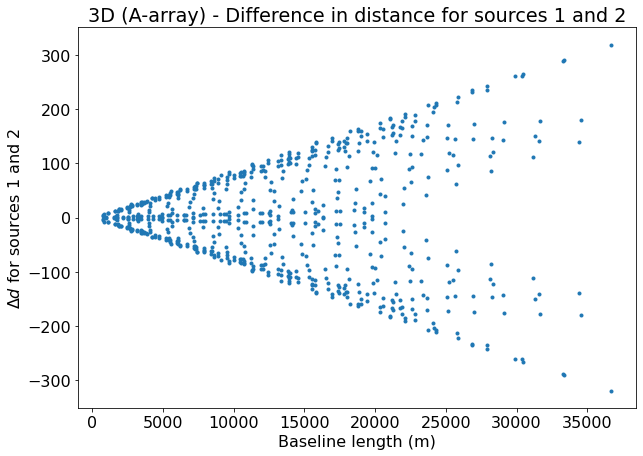

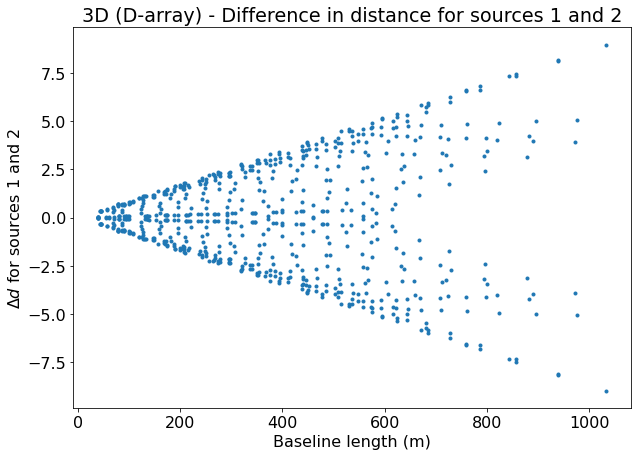

In [529]:
source_vector1 = [0, np.sin(theta1), np.cos(theta1)]
source_vector2 = [0, np.sin(theta2), np.cos(theta2)]

baseline_vectorA = [uv_3dA[:,0], uv_3dA[:,1], uv_3dA[:,2]]
baseline_vectorD = [uv_3dD[:,0], uv_3dD[:,1], uv_3dD[:,2]]

pd_3d_1A = np.dot(source_vector1, baseline_vectorA)
pd_3d_2A = np.dot(source_vector2, baseline_vectorA)
pd_3d_1D = np.dot(source_vector1, baseline_vectorD)
pd_3d_2D = np.dot(source_vector2, baseline_vectorD)

diff_3dA = pd_3d_1A - pd_3d_2A
diff_3dD = pd_3d_1D - pd_3d_2D

baseline_lengthsA = np.sqrt(uv_3dA[:,0]**2 + uv_3dA[:,1]**2 + uv_3dA[:,2]**2)  # baseline lengths
baseline_lengthsD = np.sqrt(uv_3dD[:,0]**2 + uv_3dD[:,1]**2 + uv_3dD[:,2]**2)  # baseline lengths

plt.plot(baseline_lengthsA, diff_3dA, '.')
plt.xlabel('Baseline length (m)')
plt.ylabel('$\Delta d$ for sources 1 and 2')
plt.title('3D (A-array) - Difference in distance for sources 1 and 2')
plt.show()

plt.plot(baseline_lengthsD, diff_3dD, '.')
plt.xlabel('Baseline length (m)')
plt.ylabel('$\Delta d$ for sources 1 and 2')
plt.title('3D (D-array) - Difference in distance for sources 1 and 2')
plt.show()

In [530]:
diff_diffA = diff_2dA - diff_3dA
diff_diffD = diff_2dD - diff_3dD
RMS_diffA = np.sqrt(mean_squared_error(diff_diffA, np.zeros(len(diff_diffA))))
RMS_diffD = np.sqrt(mean_squared_error(diff_diffD, np.zeros(len(diff_diffD))))

print('A-array RMS difference = {} m'.format(round(RMS_diffA, 2)))
print()
print('D-array RMS difference = {} m'.format(round(RMS_diffD, 2)))

A-array RMS difference = 0.34 m

D-array RMS difference = 0.01 m


In [531]:
wav14 = cons.c / (1.4 * u.GHz).to(u.s**-1)
wav80 = cons.c / (8.0 * u.GHz).to(u.s**-1)

print('wavelength for 1.4GHz = {} m'.format(wav14, 2))
print('wavelength for 8.0GHz = {} m'.format(wav80, 2))

wavelength for 1.4GHz = 0.21413747 m m
wavelength for 8.0GHz = 0.03747405725 m m


## d) phase difference

In this part, we look at the phase difference for a source at $1 \ FWHM$ from the pointing center when the pointing center is at the equator or directly overhead the VLA. 

We repeat the calculations for both A and D-arrays because they have different $FWHM$s and also repeat it for 2 frequencies, $\nu = 1.4 \ GHz$ and $\nu = 8.0 \ GHz$. 

We know that if the phase difference is much smaller than a radian, we have no problem in ignoring the $w$-term. However, if it approaches 1 or surpasses it, that implies we need to consider the effect of the vertical scatter of the antennas on our calculations. 

Based on my results, the phase differences for the pointing center directly overhead were:

$$\Delta \phi_A = 0.0005, \ \ \ \ \ \ \ \ \Delta \phi_D = 0.0003, \ \ \ \ \ \ \ \nu = 1.4 \ GHz$$
$$\Delta \phi_A = 0.003, \ \ \ \ \ \ \ \ \ \Delta \phi_D =0.002, \ \ \ \ \ \ \ \ \ \nu = 8.0 \ GHz$$

We see that all of these values are quite a bit smaller than 1, and so the w-term can be ignored for sources $1 FWHM$ away from poiting centre for both frequencies if the poiting centre is directly overhead. 

Now, for the poiting centre at the equator, we have:

$$\Delta \phi_A = 0.2, \ \ \ \ \ \ \ \ \Delta \phi_D = 0.1, \ \ \ \ \ \ \ \nu = 1.4 \ GHz$$
$$\Delta \phi_A = 0.9, \ \ \ \ \ \ \ \ \ \Delta \phi_D = 0.5, \ \ \ \ \ \ \ \ \ \nu = 8.0 \ GHz$$

So we see that all of these are larger than the above, meaning in general the w-term will have a stronger effect for the pointing centre being at the equator. We see that the numbers alsso get closer to 1 for both A and D-arrays for the higher frequency. Even though the phase difference for the A-array is closer to 1, the value for the D-array is no longer in the "much smaller than 1" territory, therefore could also cause problems if neglecting the w-term. 

Based on these values, the case where we have higher frequency observations while the poiting centre is at the equator is the one where we have to worry about the w term for both A and D-arrays. 

In [519]:
def phase_diff_2d(dec, wav, fwhmA, fwhmD):

    zenith = [np.cos(dec), 0, np.sin(dec)]
    east = [0, 1, 0]
    north = np.cross(zenith, east)

    mat = np.vstack([north,east,zenith])

    xyza = vlaA@mat.T
    xyzd = vlaD@mat.T

    uvA = np.zeros([nvis, 2])
    uvD = np.zeros([nvis, 2])
    icur = 0
    for i in range(nant):
        for j in range(i+1,nant):
            uvA[icur,:] = xyza[i,:2] - xyza[j,:2]
            uvD[icur,:] = xyzd[i,:2] - xyzd[j,:2]
            icur += 1

    uvA = np.vstack([uvA,-1*uvA]) #get the visibility conjugates
    uvD = np.vstack([uvD,-1*uvD])
    
    zenithA = [np.cos(dec+fwhmA), 0, np.sin(dec+fwhmA)]
    zenithD = [np.cos(dec+fwhmD), 0, np.sin(dec+fwhmD)]

    east = [0, 1, 0]
    northA = np.cross(zenithA, east)
    northD = np.cross(zenithD, east)

    matA = np.vstack([northA,east,zenithA])
    matD = np.vstack([northD,east,zenithD])

    xyza = vlaA@matA.T
    xyzd = vlaD@matD.T

    uvA_shift = np.zeros([nvis, 2])
    uvD_shift = np.zeros([nvis, 2])
    icur = 0
    for i in range(nant):
        for j in range(i+1,nant):
            uvA_shift[icur,:] = xyza[i,:2] - xyza[j,:2]
            uvD_shift[icur,:] = xyzd[i,:2] - xyzd[j,:2]
            icur += 1

    uvA_shift = np.vstack([uvA_shift,-1*uvA_shift]) #get the visibility conjugates
    uvD_shift = np.vstack([uvD_shift,-1*uvD_shift])

    mag2d_shiftA = np.sqrt((uvA_shift*uvA_shift).sum(axis=1))
    mag2dA = np.sqrt((uvA*uvA).sum(axis=1))

    mag2d_shiftD = np.sqrt((uvD_shift*uvD_shift).sum(axis=1))
    mag2dD = np.sqrt((uvD*uvD).sum(axis=1))
    
    phase_diffA = (mag2dA - mag2d_shiftA)/wav
    phase_diffD = (mag2dD - mag2d_shiftD)/wav

    RMS_diff2dA = np.sqrt(mean_squared_error(phase_diffA, np.zeros(len(phase_diffA))))
    RMS_diff2dD = np.sqrt(mean_squared_error(phase_diffD, np.zeros(len(phase_diffD))))
    
    return RMS_diff2dA, RMS_diff2dD

In [404]:
def phase_diff_3d(dec, wav, fwhmA, fwhmD):
    
    zenith = [np.cos(dec), 0, np.sin(dec)]
    east = [0, 1, 0]
    north = np.cross(zenith, east)

    mat = np.vstack([north,east,zenith])

    xyza = vlaA@mat.T
    xyzd = vlaD@mat.T

    zenithA = [np.cos(dec+fwhmA), 0, np.sin(dec+fwhmA)]
    zenithD = [np.cos(dec+fwhmD), 0, np.sin(dec+fwhmD)]

    east = [0, 1, 0]
    northA = np.cross(zenithA, east)
    northD = np.cross(zenithD, east)

    matA = np.vstack([northA,east,zenithA])
    matD = np.vstack([northD,east,zenithD])

    xyza_shift = vlaA@matA.T
    xyzd_shift = vlaD@matD.T

    mag3dA = np.sqrt((xyza*xyza).sum(axis=1))
    mag3d_shiftA = np.sqrt((xyza_shift*xyza_shift).sum(axis=1))

    mag3dD = np.sqrt((xyzd*xyzd).sum(axis=1))
    mag3d_shiftD = np.sqrt((xyzd_shift*xyzd_shift).sum(axis=1))
    
    phase_diffA = (mag3dA - mag3d_shiftA)/wav
    phase_diffD = (mag3dD - mag3d_shiftD)/wav

    RMS_diff3dA = np.sqrt(mean_squared_error(phase_diffA, np.zeros(len(phase_diffA))))
    RMS_diff3dD = np.sqrt(mean_squared_error(phase_diffD, np.zeros(len(phase_diffD))))
    
    return RMS_diff3dA, RMS_diff3dD

#### Poiting centre directly overhead

In [517]:
dec = lat

# 1.4 GHz
wav = cons.c / (1.4 * u.GHz).to(u.s**-1)
RMS_diff2dA, RMS_diff2dD = phase_diff_2d(dec, wav.value, fwhmA, fwhmD)
RMS_diff3dA, RMS_diff3dD = phase_diff_3d(dec, wav.value, fwhmA, fwhmD)

print('A array ', RMS_diff2dA - RMS_diff3dA)
print('D array ', RMS_diff2dD - RMS_diff3dD)

print()

# 8 GHz
wav = cons.c / (8 * u.GHz).to(u.s**-1)
RMS_diff2dA, RMS_diff2dD = phase_diff_2d(dec, wav.value, fwhmA, fwhmD)
RMS_diff3dA, RMS_diff3dD = phase_diff_3d(dec, wav.value, fwhmA, fwhmD)

print('A array ', RMS_diff2dA - RMS_diff3dA)
print('D array ', RMS_diff2dD - RMS_diff3dD)

A array  0.0005045190307481239
D array  0.0002718648071820683

A array  0.0028829658899892797
D array  0.001553513183897533


#### Pointing centre at equator

In [518]:
dec = 0

# 1.4 GHz
wav = cons.c / (1.4 * u.GHz).to(u.s**-1)
RMS_diff2dA, RMS_diff2dD = phase_diff_2d(dec, wav.value, fwhmA, fwhmD)
RMS_diff3dA, RMS_diff3dD = phase_diff_3d(dec, wav.value, fwhmA, fwhmD)

print('A array ', RMS_diff2dA - RMS_diff3dA)
print('D array ', RMS_diff2dD - RMS_diff3dD)

print()

# 8 GHz
wav = cons.c / (8 * u.GHz).to(u.s**-1)
RMS_diff2dA, RMS_diff2dD = phase_diff_2d(dec, wav.value, fwhmA, fwhmD)
RMS_diff3dA, RMS_diff3dD = phase_diff_3d(dec, wav.value, fwhmA, fwhmD)

print('A array ', RMS_diff2dA - RMS_diff3dA)
print('D array ', RMS_diff2dD - RMS_diff3dD)

A array  0.1631535708747663
D array  0.09219411906222198

A array  0.9323061192843789
D array  0.5268235374984114


# Problem 3: Frequency Smearing

For this problem, we look at a source directly overhead and a source that is $1 FWHM$ south from the poiting centre (for both A and D-array). Because the UV coordinates (when measured in wavelengths), are frequency dependent, we see that that as we observe at different frequencies, we get different path length differences. Below, I calculate the path length difference for this source for a varity of frequencies that are a value $d\nu$ apart from each other for the 2 array configurations. The objective is to find the $d\nu$ for which the path length differences change by as much as $\frac{\lambda}{2\pi}$ when changing the frequency by $d\nu$.

The results are shown in the graph below, for which we see that a difference of $\frac{\lambda}{2\pi}$ is reached much sooner for the A-array, as expected due to its greater extent. In order for both of the array configurations to show a difference in path length differences of the desired amount, the shift in frequency $d\nu$ required was:

$$d\nu \approx 0.22 \ GHz $$

This is quite a small value, so it makes sense that a large number of frequency channels are required so that there is only a small range of frequencies $\leq 0.22 \ GHz$ in each band to avoid the smearing. 

In [548]:
def calc_path_diff(wav):
    
    theta1 = 0
    theta2A = -fwhmA
    theta2D = -fwhmD

    source_vector1 = [0, np.sin(theta1), np.cos(theta1)]
    source_vector2A = [0, np.sin(theta2A), np.cos(theta2A)]
    source_vector2D = [0, np.sin(theta2D), np.cos(theta2D)]

    baseline_vectorA = [uv_3dA[:,0]/wav, uv_3dA[:,1]/wav, uv_3dA[:,2]/wav]
    baseline_vectorD = [uv_3dD[:,0]/wav, uv_3dD[:,1]/wav, uv_3dD[:,2]/wav]

    pd_3d_1A = np.dot(source_vector1, baseline_vectorA)
    pd_3d_2A = np.dot(source_vector2A, baseline_vectorA)
    pd_3d_1D = np.dot(source_vector1, baseline_vectorD)
    pd_3d_2D = np.dot(source_vector2D, baseline_vectorD)

    diff_3dA = pd_3d_1A - pd_3d_2A
    diff_3dD = pd_3d_1D - pd_3d_2D
    
    RMS_diffA = np.sqrt(mean_squared_error(diff_3dA, np.zeros(len(diff_3dA))))
    RMS_diffD = np.sqrt(mean_squared_error(diff_3dD, np.zeros(len(diff_3dD))))

    return RMS_diffA, RMS_diffD

In [566]:
dfs = np.linspace(0, 0.5, 200)
diffsA = []
diffsD = []
for df in dfs:
    A1, D1 = calc_path_diff(cons.c / (1.4 * u.GHz).to(u.s**-1))
    A2, D2 = calc_path_diff(cons.c / ((1.4+df) * u.GHz).to(u.s**-1))
    diffsA.append(np.abs(A1 - A2))
    diffsD.append(np.abs(D1 - D2))

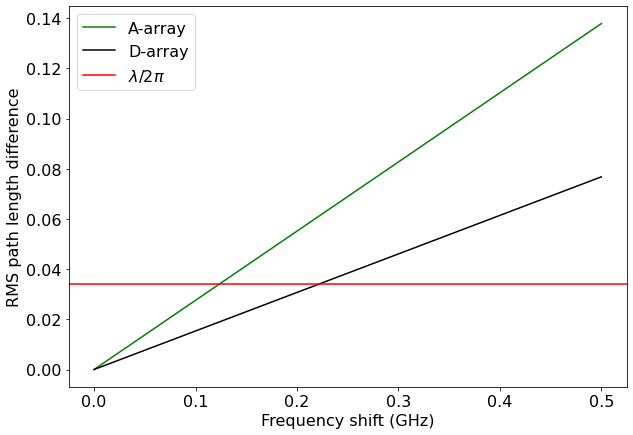

In [598]:
w = ((cons.c / (1.4 * u.GHz).to(u.s**-1)) / (2*np.pi)).value
plt.plot(dfs, diffsA, color='green', label='A-array')
plt.plot(dfs, diffsD, color='black', label='D-array')
plt.axhline(w, color='red', label='$\lambda / 2\pi$')
plt.xlabel('Frequency shift (GHz)')
plt.ylabel('RMS path length difference')
plt.legend()
plt.show()

In [601]:
f_ind = np.argmin(np.abs(diffsD - ((cons.c / (1.4 * u.GHz).to(u.s**-1)) / (2*np.pi)).value))
f_min = dfs[f_ind]
print('frequency difference', f_min)

frequency difference 0.22110552763819097


# Problem 4: Confusion Limit

## a) Euclidean proportionality

If all sources have the same intrisic brightness $s$, that is higher than some lower limit, then their measured flux will fall as their distance squared.

$$s \propto r^{-2}$$

Or if we rearange this equation, 

$$r \propto s^{-1/2}$$

If now additionally these sources are uniformly distributed in space, then the number of sources will grow linearly with growing volume. The volume, in turn, will grow as the cube of the radius, given that we have a spherical volume.

$$N \propto V \propto r^3$$

Combining this with the previous proportionality, we have that

$$N \propto r^3 \propto (s^{-1/2})^3$$

$$\longrightarrow N(S) \propto s^{-3/2}$$

## b) Confusion level for different instruments

To get the confusion level, I took the effective beam size of the instrument and multiplied it by how the number of sources brighter than $1 \ mJy$. This will give us the variance of the sky measurement due to those unresolved but detected sources in the beam. Then, to find the confusion limit, we take the square root of that to report the standard deviation. Below are the values I found:

$$S_{lim, VLA-A} = 0.004 \ mJy$$
$$S_{lim, VLA-D} = 0.1 \ mJy$$
$$S_{lim, FAST} = 0.5 \ mJy$$
$$S_{lim, GBT} = 1.5 \ mJy$$

We note the trend that is expected, which is that for instruments with larger effective diameters and therefore smaller beam sizes, we have a lower confusion limit. In particular, for the VLA, which used interferometry, the effective diameter is much larger and therefore the limit is significantly lowe (especially for the A configuration). 

In [664]:
d_A = baseline_lengthsA.max()
d_D = baseline_lengthsD.max()

In [658]:
theta_GBT = ((1.22 * wav.value / 100)*u.rad).to(u.arcmin)
print(theta_GBT)
spb_GBT = 100*(theta_GBT.value/60)**2
print(spb_GBT, 'sources per beam')
cl_GBT = np.sqrt(spb_GBT)
print(cl_GBT, ' mJy confusion limit')

8.981034831157993 arcmin
2.240527406624252 sources per beam
1.4968391385263322  mJy confusion limit


In [661]:
theta_FAST = ((1.22 * wav.value / 300)*u.rad).to(u.arcmin)
print(theta_FAST)
spb_FAST = 100*(theta_FAST.value/60)**2
print(spb_FAST, 'sources per beam')
cl_FAST = np.sqrt(spb_FAST)
print(cl_FAST, ' mJy confusion limit')

2.9936782770526644 arcmin
0.24894748962491697 sources per beam
0.49894637950877746  mJy confusion limit


In [665]:
theta_A = ((1.22 * wav.value / d_A)*u.rad).to(u.arcmin)
print(theta_A)
spb_A = 100*(theta_A.value/60)**2
print(spb_A, 'sources per beam')
cl_A = np.sqrt(spb_A)
print(cl_A, ' mJy confusion limit')

0.024505918531458306 arcmin
1.6681667863068656e-05 sources per beam
0.004084319755243051  mJy confusion limit


In [666]:
theta_D = ((1.22 * wav.value / d_D)*u.rad).to(u.arcmin)
print(theta_D)
spb_D = 100*(theta_D.value/60)**2
print(spb_D, 'sources per beam')
cl_D = np.sqrt(spb_D)
print(cl_D, ' mJy confusion limit')

0.8703307403872598 arcmin
0.021040988823973216 sources per beam
0.14505512339787663  mJy confusion limit


## c) Integrating time

In order to find the times to reach confusion limits for each of the instruments, I had to find their effective areas, given by:

$$A_{eff} = 0.7 \pi r^2$$

Where for the single dish telescopes, I used their actual given radius and for the interforometer I used half the longest baseline. 

With that I was able to find the gain to convert from flux units to temperature units, using:

$$gain = \frac{A_{eff}}{2k_B}$$

Then, using the radiometer equation, I solved for the observing time, giving me:

$$t = \frac{1}{B}\left(\frac{T_{sys}}{\delta T}\right)^2$$

The results I got were:

$$t_{VLA-A} = 1.04 \times 10^{-6} \ s$$
$$t_{VLA-D} = 0.001 \ s$$
$$t_{FAST} = 0.02 \ s$$
$$t_{GBT} = 1.3 \ s$$

In [741]:
B = (500 * u.MHz).to(u.s**-1)
Tsys = 25*u.K

In [749]:
A_GBT = 0.7 * np.pi * (50)**2 * u.m**2
gain_GBT = (A_GBT / (2 * cons.k_B)).to(u.K / u.Jy)
dT_GBT = (gain_GBT * cl_GBT*u.mJy).to(u.K)
t_GBT = 1/B * (Tsys/dT_GBT)**2
print('GBT')
print(t_GBT)

GBT
1.2666393494486148 s


In [750]:
A_FAST = 0.7 * np.pi * (150)**2 * u.m**2
gain_FAST = (A_FAST / (2 * cons.k_B)).to(u.K / u.Jy)
dT_FAST = (gain_FAST * cl_FAST*u.mJy).to(u.K)
t_FAST = 1/B * (Tsys/dT_FAST)**2
print('FAST')
print(t_FAST)

FAST
0.015637522832698935 s


In [751]:
A_A = 0.7 * np.pi * (d_A/2)**2 * u.m**2
gain_A = (A_A / (2 * cons.k_B)).to(u.K / u.Jy)
dT_A = (gain_A * cl_A*u.mJy).to(u.K)
t_A = 1/B * (Tsys/dT_A)**2
print('VLA - A')
print(t_A)

VLA - A
1.0478513460379433e-06 s


In [752]:
A_D = 0.7 * np.pi * (d_D/2)**2 * u.m**2
gain_D = (A_D / (2 * cons.k_B)).to(u.K / u.Jy)
dT_D = (gain_D * cl_D*u.mJy).to(u.K)
t_D = 1/B * (Tsys/dT_D)**2
print('VLA - D')
print(t_D)

VLA - D
0.0013216801007039053 s


## d) same thing for different parameters

Now we repeated parts b) and c) but using $\nu = 8 \ GHz$ and $B = 2 \ GHz$. In addition we are told that the spectral index is $-0.8$. Therefore, we can recalculate the number of sources we will have above $1 \ mJy$ as follows:

$$\frac{100}{N} = \frac{s_{1.4}^{-3/2}}{\left(\frac{8}{1.4}\right)^{0.8}s_{1.4}^{-3/2}} \longrightarrow N = 100 \left( \frac{1.4}{8}\right)^{0.8} \approx 25$$

Then, repeating the steps we get the following results:

$$S_{lim, VLA-A} = 0.0004 \ mJy$$
$$S_{lim, VLA-D} = 0.01 \ mJy$$
$$S_{lim, FAST} = 0.04 \ mJy$$
$$S_{lim, GBT} = 0.13 \ mJy$$

These are all aproximately an order of magnitude lower than what we previously had. And for the observing times to reach these limits, we have:

$$t_{VLA-A} = 3.4 \times 10^{-5} \ s$$
$$t_{VLA-D} = 0.04 \ s$$
$$t_{FAST} = 0.5 \ s$$
$$t_{GBT} = 4.6 \ s$$

Which are all higher than we previously had. 

In [769]:
wav_new = cons.c / (8 * u.GHz).to(u.s**-1)
N = 100*(1.4/8)**(0.8)

In [774]:
theta_GBT = ((1.22 * wav_new.value / 100)*u.rad).to(u.arcmin)
spb_GBT = N*(theta_GBT.value/60)**2
cl_GBT = np.sqrt(spb_GBT)
print(cl_GBT, ' mJy confusion limit - GBT')

theta_FAST = ((1.22 * wav_new.value / 300)*u.rad).to(u.arcmin)
spb_FAST = N*(theta_FAST.value/60)**2
cl_FAST = np.sqrt(spb_FAST)
print(cl_FAST, ' mJy confusion limit - FAST')

theta_A = ((1.22 * wav_new.value / d_A)*u.rad).to(u.arcmin)
spb_A = N*(theta_A.value/60)**2
cl_A = np.sqrt(spb_A)
print(cl_A, ' mJy confusion limit - VLA-A')

theta_D = ((1.22 * wav_new.value / d_D)*u.rad).to(u.arcmin)
spb_D = N*(theta_D.value/60)**2
cl_D = np.sqrt(spb_D)
print(cl_D, ' mJy confusion limit - VLA-D')

0.13044528876419711  mJy confusion limit - GBT
0.04348176292139905  mJy confusion limit - FAST
0.00035593689139003107  mJy confusion limit - VLA-A
0.012641142906639329  mJy confusion limit - VLA-D


In [777]:
B = (2 * u.GHz).to(u.s**-1)

In [778]:
A_GBT = 0.7 * np.pi * (50)**2 * u.m**2
gain_GBT = (A_GBT / (2 * cons.k_B)).to(u.K / u.Jy)
dT_GBT = (gain_GBT * cl_GBT*u.mJy).to(u.K)
t_GBT = 1/B * (Tsys/dT_GBT)**2
print('GBT')
print(t_GBT)

A_FAST = 0.7 * np.pi * (150)**2 * u.m**2
gain_FAST = (A_FAST / (2 * cons.k_B)).to(u.K / u.Jy)
dT_FAST = (gain_FAST * cl_FAST*u.mJy).to(u.K)
t_FAST = 1/B * (Tsys/dT_FAST)**2
print('FAST')
print(t_FAST)

A_A = 0.7 * np.pi * (d_A/2)**2 * u.m**2
gain_A = (A_A / (2 * cons.k_B)).to(u.K / u.Jy)
dT_A = (gain_A * cl_A*u.mJy).to(u.K)
t_A = 1/B * (Tsys/dT_A)**2
print('VLA - A')
print(t_A)

A_D = 0.7 * np.pi * (d_D/2)**2 * u.m**2
gain_D = (A_D / (2 * cons.k_B)).to(u.K / u.Jy)
dT_D = (gain_D * cl_D*u.mJy).to(u.K)
t_D = 1/B * (Tsys/dT_D)**2
print('VLA - D')
print(t_D)

GBT
4.632804124979735 s
FAST
0.5147560138866367 s
VLA - A
3.4493173106954535e-05 s
VLA - D
0.04350706870585637 s
